In [1]:
import numpy as np
from sklearn.datasets import make_classification, make_moons, make_blobs

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [2]:
# print(torch.cuda.is_available()) 
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
data = [make_blobs(n_samples=200, centers=2, cluster_std=.7, n_features=2, random_state=0),
        make_moons(n_samples=200, noise=.1, random_state=0),
        make_classification(n_samples=200, n_features=2, n_informative=2, 
                            n_redundant=0, n_repeated=0, n_classes=3, class_sep=1.8,
                            n_clusters_per_class=1, random_state=0)]

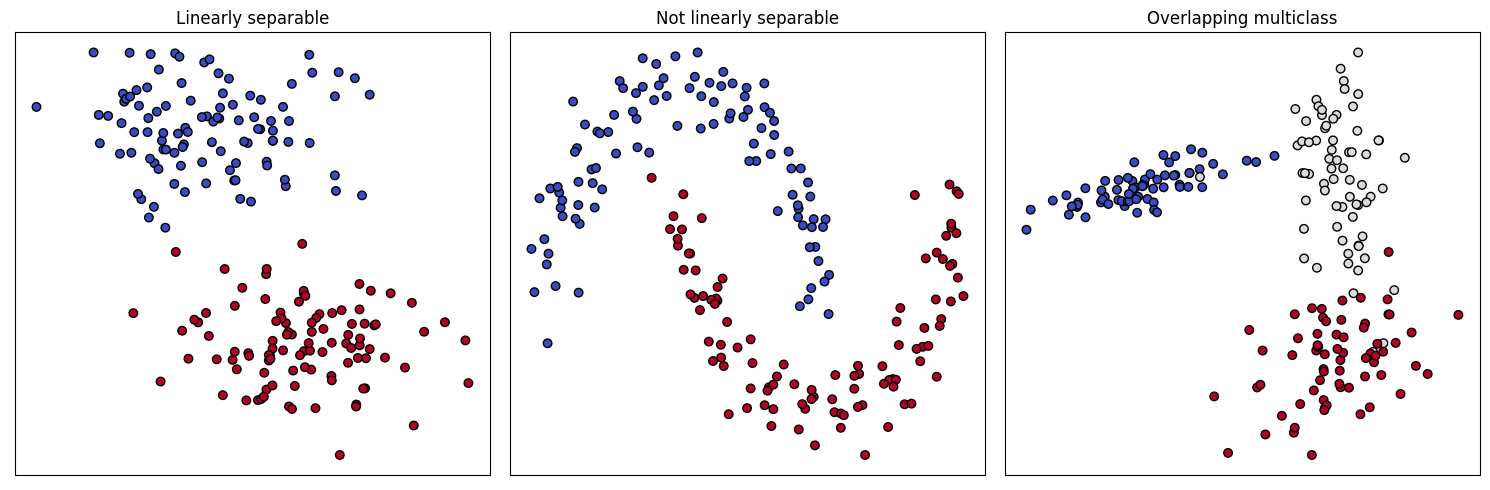

In [4]:
def plot_classification(classifiers=None):
  fig = plt.figure(figsize=(15, 5), dpi=100)
  ax = fig.subplots(1, 3)
  titles = ['Linearly separable', 'Not linearly separable', 'Overlapping multiclass']
  for i, (X, y) in enumerate(data):
    ax[i].scatter(X[:, 0], X[:, 1], c=y, s=150, marker='.', edgecolor='k', cmap='coolwarm')
    ax[i].set_title(titles[i])
    if classifiers is not None:
      a = ax[i].axis()
      XX, YY = np.meshgrid(np.linspace(a[0], a[1], 200),
                          np.linspace(a[2], a[3], 200))
      X_test = torch.Tensor(np.concatenate([np.vstack(XX.ravel()), 
                                            np.vstack(YY.ravel())], axis=1))
      Z = classifiers[i].predict(X_test)
      # ax[i].contourf(XX, YY, Z.reshape(XX.shape), alpha=.5, cmap='coolwarm', zorder=-1)#, levels=np.arange(y.min()+0.5, y.max()))
      ax[i].pcolor(XX, YY, Z.reshape(XX.shape), alpha=.5, cmap='coolwarm', edgecolors='none', snap=True, zorder=-1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
  fig.tight_layout()
  fig.show()

plot_classification()

In [5]:
import torch
import torch.nn as nn

class FeedforwardClassifier(nn.Module):
  def __init__(self, n_iter=20, n_hidden=8, n_classes=2, learning_rate=1, verbose=False, random_seed=None):
    """Simple classifier for 2D data"""
    super(FeedforwardClassifier, self).__init__()
    self.n_iter = n_iter
    assert n_iter > 0
    self.verbose = verbose
    if random_seed is not None:
      torch.manual_seed(random_seed)
    # Define layers
    if n_hidden == 0:
      self.net = nn.Sequential(nn.Linear(2, n_classes),
                               nn.Softmax(dim=1))
    else:
      self.net = nn.Sequential(nn.Linear(2, n_hidden),
                               nn.ReLU(),
                               nn.Linear(n_hidden, n_classes),
                               nn.Softmax(dim=1))
    # Define optimiser and loss
    self.optimizer_ = torch.optim.SGD(self.parameters(), lr=learning_rate)
    self.loss_function_ = nn.CrossEntropyLoss()
    # For making nice plots
    self.training_loss_ = list()
    self.training_accuracy_ = list()

  def forward(self, X):
    """Forward pass, this is used for making predictions."""
    return self.net(X)

  def _reset(self):
    """Reset the model weights."""
    # There has to be a simpler way to do this
    for _, module in self.named_children():
      if hasattr(module, 'reset_parameters'):
        module.reset_parameters()
      if hasattr(module, 'named_children'):
        for _, submodule in module.named_children():
          if hasattr(submodule, 'reset_parameters'):
            submodule.reset_parameters()
  
  def fit(self, X, y):
    """Train the model"""
    self._reset()
    for epoch in range(self.n_iter):
      self._fit(X, y)
      if self.verbose:
        if self.n_iter < 50 or (epoch % 50) == 0:
          print("Epoch %2i: Loss %.7f" % (epoch, self._loss.item()))
    return self

  def _fit(self, X, y):
    """A single step in the training"""
    self.zero_grad()              # Reset gradients
    forward_pass_output = self(X) # Forward pass
    self._loss = self.loss_function_(forward_pass_output, y) # Calculate loss
    self._loss.backward()         # Backward pass
    self.optimizer_.step()        # Run the optimizer one step
    # Store values for user feedback
    self.training_loss_.append(self._loss.item())
    self.training_accuracy_.append(self.score(X, y))

  def predict(self, X):
    """Predict labels"""
    return np.argmax(self.predict_proba(X), axis=1) # Pick max probabilities

  def predict_proba(self, X):
    """Predict label probabilities"""
    with torch.no_grad():         # Disable gradient calculations
      log_probs = self(X)         # Forward pass to predict probabilities
    return log_probs.detach().numpy()

  def score(self, X, y):
    """Get the accuracy of the model given the data"""
    return np.sum(self.predict(X)==y.numpy())/len(y)

  def copy(self):
    import copy
    return copy.deepcopy(self)

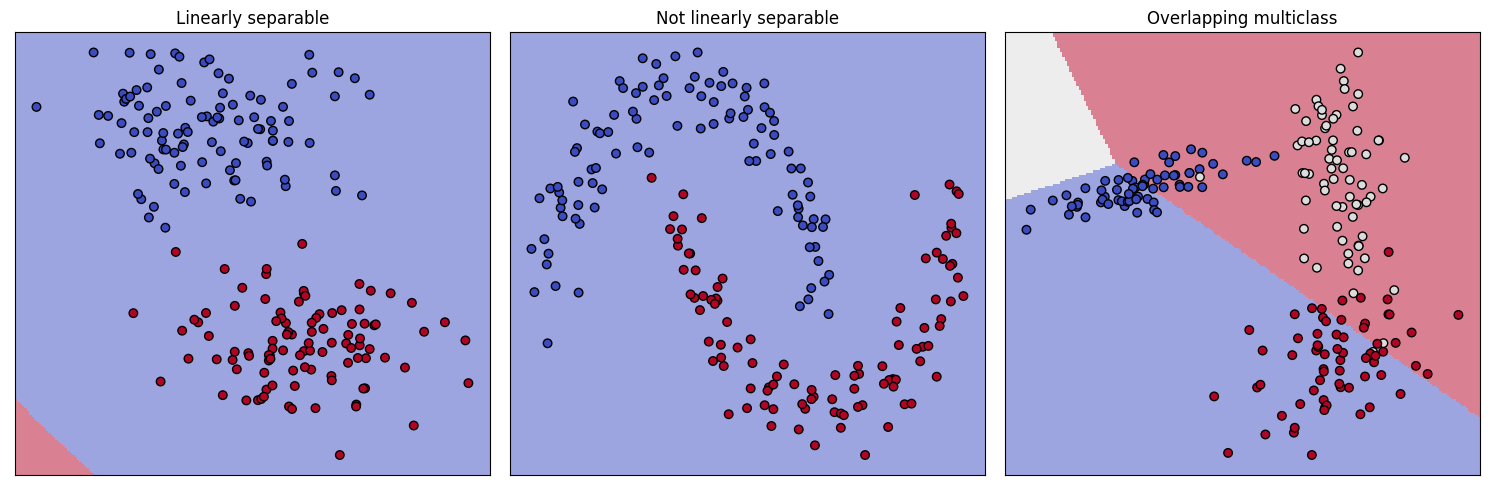

In [6]:
classifiers = [FeedforwardClassifier(n_iter=50, n_hidden=0),
               FeedforwardClassifier(n_iter=500, n_hidden=10),
               FeedforwardClassifier(n_iter=50, n_hidden=0, n_classes=3)]

plot_classification(classifiers)

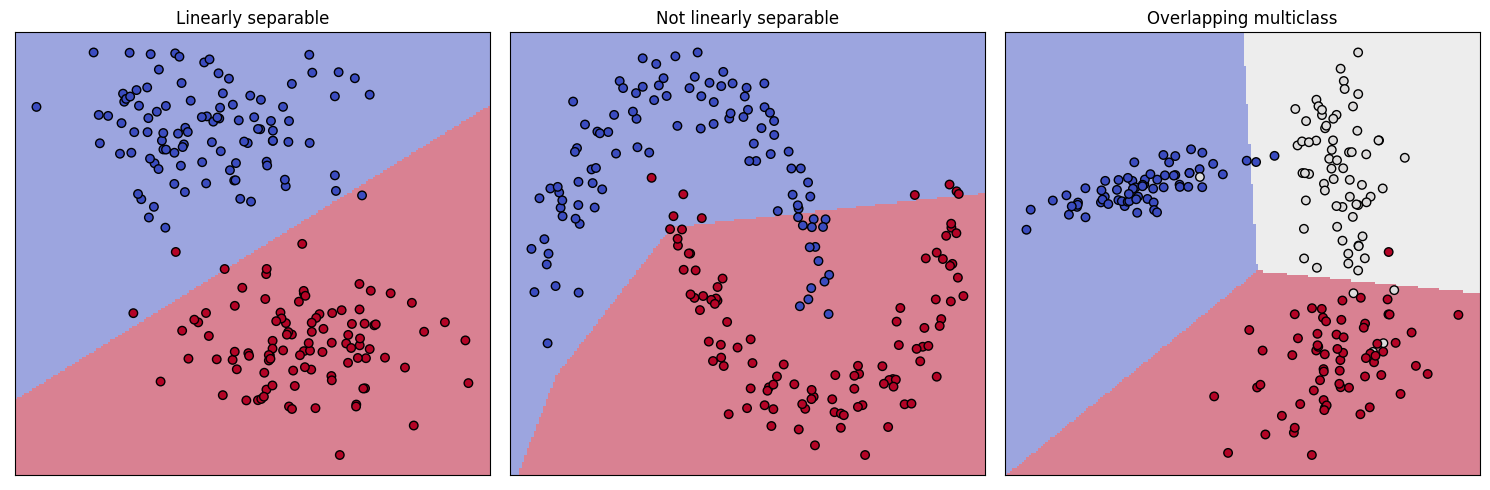

In [7]:
for classifier, (X, y) in zip(classifiers, data):
  X = torch.Tensor(X)
  y = torch.LongTensor(y)
  classifier.fit(X, y)

plot_classification(classifiers)

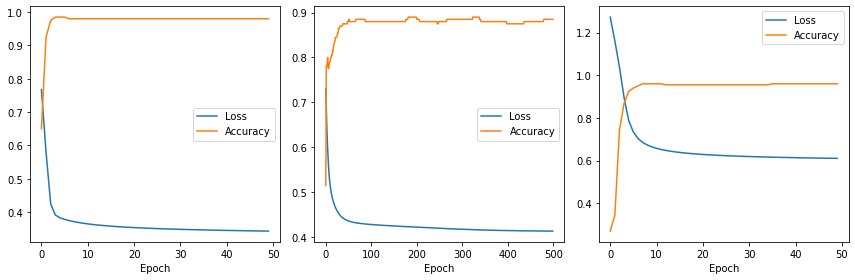

In [8]:
fig = plt.figure(figsize=(4*len(classifiers), 4))
ax = fig.subplots(1, len(classifiers))
for classifier, a in zip(classifiers, ax):
  a.plot(classifier.training_loss_, label="Loss")
  a.plot(classifier.training_accuracy_, label="Accuracy")
  a.legend()
  a.set_xlabel("Epoch")
fig.tight_layout()
fig.show()

A low learning rate makes the optimization slow. A high learning rate often "jumps over" a good minimum.

100%|██████████| 199/199 [00:11<00:00, 17.61it/s]


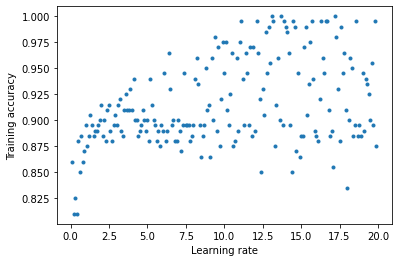

In [9]:
X, y = data[1]
X = torch.Tensor(X)
y = torch.LongTensor(y)

from tqdm import tqdm
accuracy = list()
learning_rates = np.arange(.1, 20, .1)
for lr in tqdm(learning_rates):
  model = FeedforwardClassifier(n_iter=50, n_hidden=8, learning_rate=lr)
  model.fit(X, y)
  accuracy.append(model.score(X, y))

plt.figure()
plt.plot(learning_rates, accuracy, '.')
plt.ylabel("Training accuracy")
plt.xlabel("Learning rate")
plt.show()

In [10]:
from multiprocessing import Pool
import io
import cv2

!apt-get update
!apt-get install imagemagick

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Reading package lists... Done
B

In [41]:
accuracy = list()
for seed in range(0, 50):
  model = FeedforwardClassifier(n_iter=100, n_hidden=8, learning_rate=5, random_seed=seed)
  model.fit(X, y)
  accuracy.append(model.score(X, y))
np.argmax(accuracy)

4

In [46]:
import io
import cv2
import os.path

# Create temporary space
if not os.path.exists("frames"):
  os.mkdir("frames")
else:
  files = ["frames/" + fn for fn in os.listdir("frames") if fn[-3:] == "png"]
  for file in files:
    os.remove(file)

n_iter=75
model = FeedforwardClassifier(n_hidden=8, learning_rate=5, random_seed=4)
for epoch in tqdm(range(n_iter), total=n_iter):
  model._fit(X, y)
  model._fit(X, y)
  fig = plt.figure(figsize=(1.8, 1.8), dpi=100)
  ax = fig.subplots(1, 1)
  ax.scatter(X[:, 0], X[:, 1], c=y, s=50, marker='.', edgecolor='k', cmap='coolwarm')
  a = ax.axis()
  XX, YY = np.meshgrid(np.linspace(a[0], a[1], 200),
                      np.linspace(a[2], a[3], 200))
  X_test = torch.Tensor(np.concatenate([np.vstack(XX.ravel()), 
                                        np.vstack(YY.ravel())], axis=1))
  # Z = model.predict(X_test)
  Z = model.predict_proba(X_test)[:, 1]
  # ax[i].contourf(XX, YY, Z.reshape(XX.shape), alpha=.5, cmap='coolwarm', zorder=-1)#, levels=np.arange(y.min()+0.5, y.max()))
  ax.pcolor(XX, YY, Z.reshape(XX.shape), alpha=.5, cmap='coolwarm', edgecolors='none', snap=True, zorder=-1)
  ax.set_xticks([])
  ax.set_yticks([])
  # fig.tight_layout(0)
  # buffer = io.BytesIO()
  # fig.savefig(buffer, format="png", dpi=100, pad_inches=0.05, bbox_inches='tight')
  fig.savefig("frames/frame%03i.png" % epoch, format="png", dpi=100, pad_inches=0.05, bbox_inches='tight')
  # buffer.seek(0)
  # raw = np.frombuffer(buffer.getvalue(), dtype=np.uint8)
  # buffer.close()
  # image = cv2.imdecode(raw, 1)
  # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.close(fig)
  # cv2.imwrite("frames/frame%03i.png" % epoch, image)

100%|██████████| 75/75 [01:06<00:00,  1.14it/s]


In [47]:
!convert -delay 10 -loop 0 -depth 6 frames/frame*.png nn_training.gif